In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import time

In [3]:
cars_df = pd.read_csv("data/car_evaluation.csv", names = ["buying","maint", "doors", "persons", "lug_boot","safety","class"])
cars_df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
cleanup_nums = {"class":     {"unacc": 4, "acc": 3,'good': 2,'vgood':1}
                }
cars_df.replace(cleanup_nums,inplace = True)
target = cars_df['class']

In [5]:
cars_df.drop( ['class'],axis = 1,inplace = True)
cars_df_categorical = pd.get_dummies(cars_df)
cars_df_categorical.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(cars_df_categorical, target, random_state=42)

In [7]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

1296
1296
432
432


In [8]:
target.value_counts()

4    1210
3     384
2      69
1      65
Name: class, dtype: int64

In [12]:
sc=StandardScaler()
sc.fit(X_train)
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()


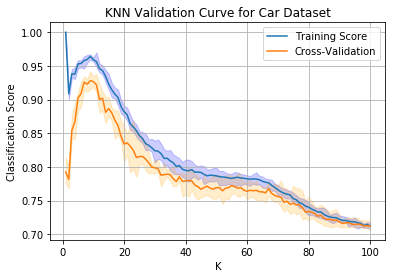

In [17]:
train_scores, test_scores = validation_curve(knn, X_train, Y_train, param_name="n_neighbors", param_range=np.arange(1,101), cv=5,
                                            n_jobs=4)
avg_train_score, avg_test_score = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)
plt.figure()
plt.plot(np.arange(1,101), avg_train_score, label='Training Score')
plt.plot(np.arange(1,101), avg_test_score, label='Cross-Validation')

plt.fill_between(np.arange(1,101), np.min(train_scores,axis=1), np.max(train_scores,axis=1),facecolor="blue", color='blue', alpha=0.2)
plt.fill_between(np.arange(1,101), np.min(test_scores,axis=1), np.max(test_scores,axis=1),facecolor="orange", color='orange', alpha=0.2)
plt.title('KNN Validation Curve for Car Dataset')
plt.xlabel('K')
plt.ylabel("Classification Score")
plt.legend()
plt.grid()
plt.show()

In [19]:
best_knn = GridSearchCV(knn, param_grid={'n_neighbors' : np.arange(1,30)}, cv=5, n_jobs=4)
train_t0 = time.time()
best_knn.fit(X_train, Y_train)
train_t1 = time.time()
t0 = time.time()
prediction = best_knn.predict(X_test)
t1 = time.time()

print('Train Time: ', train_t1 - train_t0)
print('Test Time: ', t1 - t0)
print('Top Accuracy:', (accuracy_score(Y_test, prediction) * 100))
print('Top params: ', best_knn.best_params_)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction))

Train Time:  3.651921033859253
Test Time:  0.024197816848754883
Top Accuracy: 92.5925925925926
Top params:  {'n_neighbors': 9}
[[ 13   1   6   0]
 [  1   9   5   0]
 [  1   2  85  15]
 [  0   0   1 293]]


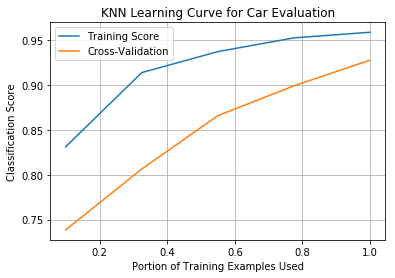

In [21]:
train_sizes, train_scores, test_scores = learning_curve(best_knn, X_train, Y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, n_jobs=4)
avg_train_score, avg_test_score = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes/train_sizes[-1], avg_train_score, label='Training Score')
plt.plot(train_sizes/train_sizes[-1], avg_test_score, label='Cross-Validation')
plt.title('KNN Learning Curve for Car Evaluation')
plt.xlabel('Portion of Training Examples Used')
plt.ylabel("Classification Score")
plt.legend()
plt.grid()
plt.show()